In [2]:
import mysql.connector

import pandas as pd

connection_mydb = mysql.connector.connect(
    host="localhost",
    user="root",
    password="",
    database="onlinemarket"
)
 
cursor = connection_mydb.cursor(dictionary=True)

In [3]:
def get_daily_sales_between_2_dates(startdate, enddate):

    df = pd.DataFrame(columns=['date','total'])
    
    sql = '''SELECT left(date_created,10) as date , sum(product_net_revenue) as total
            FROM wp_wc_order_product_lookup 
            where date_created between (%s) and (%s)
            group by date
            order by date
          '''
    
    param = (startdate, enddate)
    
    cursor.execute(sql, param)
    
    orders_results = cursor.fetchall()
    
    for order in orders_results:
        x = { "date":[order['date']], "total":[order['total']]}
        dfx = pd.DataFrame(x)
        df = pd.concat([df, dfx], ignore_index=True)
        
    return df

In [4]:
def get_last_date():
    from datetime import datetime
    
    sql = '''SELECT left(max(date_created), 10) as max_date FROM wp_wc_order_product_lookup'''
    cursor.execute(sql)
    
    results = cursor.fetchall()
    
    max = results[0]['max_date']
    
    max_datetime = datetime.strptime(max, '%Y-%m-%d')
    
    return max_datetime

In [5]:
from datetime import datetime
from datetime import timedelta

#enddate=datetime.today()
enddate = get_last_date()

startdate = enddate-timedelta(days=90)

enddate = enddate.strftime('%Y-%m-%d')
startdate = startdate.strftime('%Y-%m-%d')

df = get_daily_sales_between_2_dates(startdate, enddate)
df

,date,total
0,2023-01-12,303866.373686
1,2023-01-13,408098.753614
2,2023-01-14,282464.019749
3,2023-01-15,340937.267067
4,2023-01-16,166830.461281
...,...,...
81,2023-04-07,444414.409486
82,2023-04-08,516294.979440
83,2023-04-09,547243.145301
84,2023-04-10,502081.531535


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    86 non-null     object 
 1   total   86 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.5+ KB


In [7]:
df['date'] = pd.to_datetime(df['date'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    86 non-null     datetime64[ns]
 1   total   86 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.5 KB


In [8]:
df = df.set_index("date")

df = df.resample('D').mean()#Resamples the DataFrame to a daily frequency. 
#It groups the data by day and calculates the mean for each day. 

df['total'] = df['total'].fillna(df['total'].mean())

df = df.reset_index()

df

,date,total
0,2023-01-12,303866.373686
1,2023-01-13,408098.753614
2,2023-01-14,282464.019749
3,2023-01-15,340937.267067
4,2023-01-16,166830.461281
...,...,...
85,2023-04-07,444414.409486
86,2023-04-08,516294.979440
87,2023-04-09,547243.145301
88,2023-04-10,502081.531535


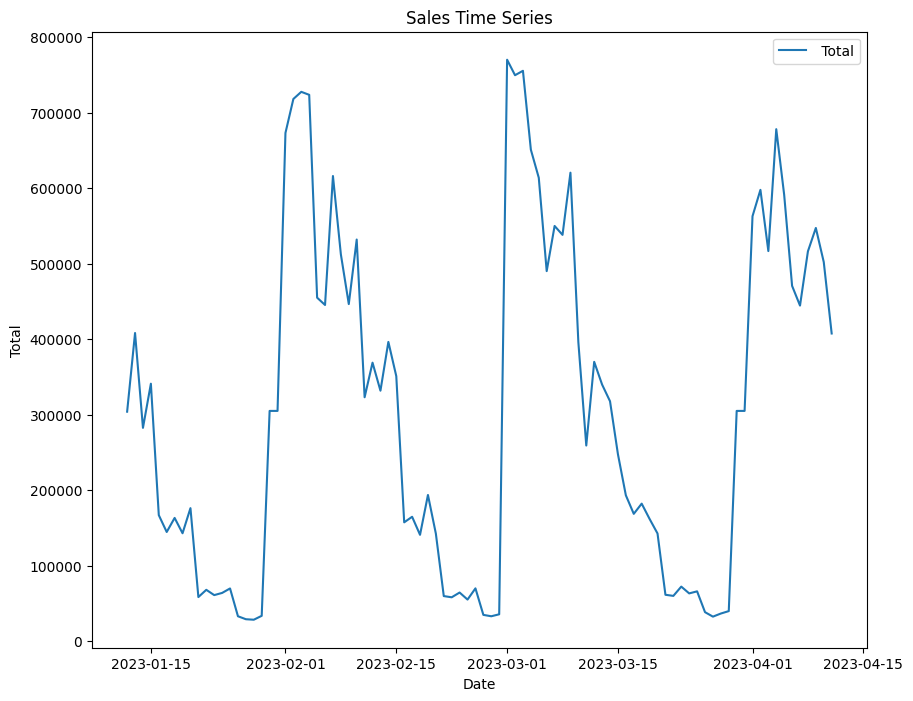

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8)) 

df = df.set_index("date")

plt.plot(df['total'] , label=' Total') 

plt.title('Sales Time Series') 

plt.xlabel("Date") 

plt.ylabel("Total") 

plt.legend(loc='best')

df = df.reset_index()

In [10]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [11]:
import plotly.express as px

figure = px.line(df, x = "date" , y = "total", title = "Sales Time Series") 

figure.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
figure = px.bar(df, x = "date" , y = "total", title = "Time Series Analysis (Bar Plot)") 

figure.show()

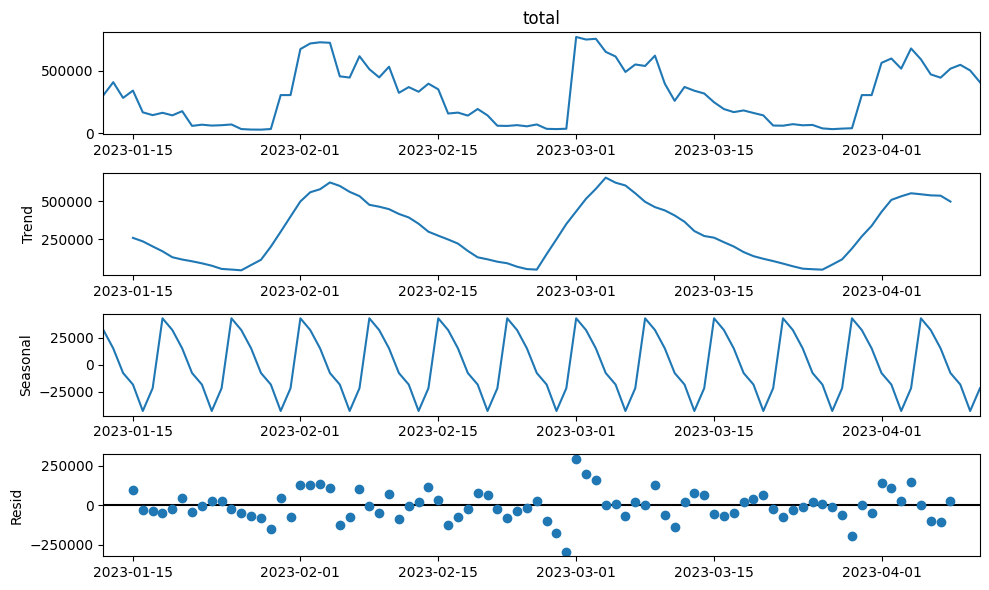

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

df = df.set_index("date")

result = seasonal_decompose(df['total'])

plt.rc("figure", figsize=(10,6))

result.plot()

df=df.reset_index()

In [12]:
pip install AutoTS

Note: you may need to restart the kernel to use updated packages.


In [13]:
from datetime import datetime
from datetime import timedelta

start = datetime.strptime(startdate,'%Y-%m-%d')
end = datetime.strptime(enddate,'%Y-%m-%d')

days = (end-start).days

endtrain = end-timedelta(days=10)

starttest = endtrain+timedelta(days=1)

endtrain = endtrain.strftime('%Y-%m-%d')
starttest = starttest.strftime('%Y-%m-%d')

In [14]:
df = df.reset_index()
df = df.set_index("date")

train = df.loc[startdate:endtrain]

test = df.loc[starttest:enddate]

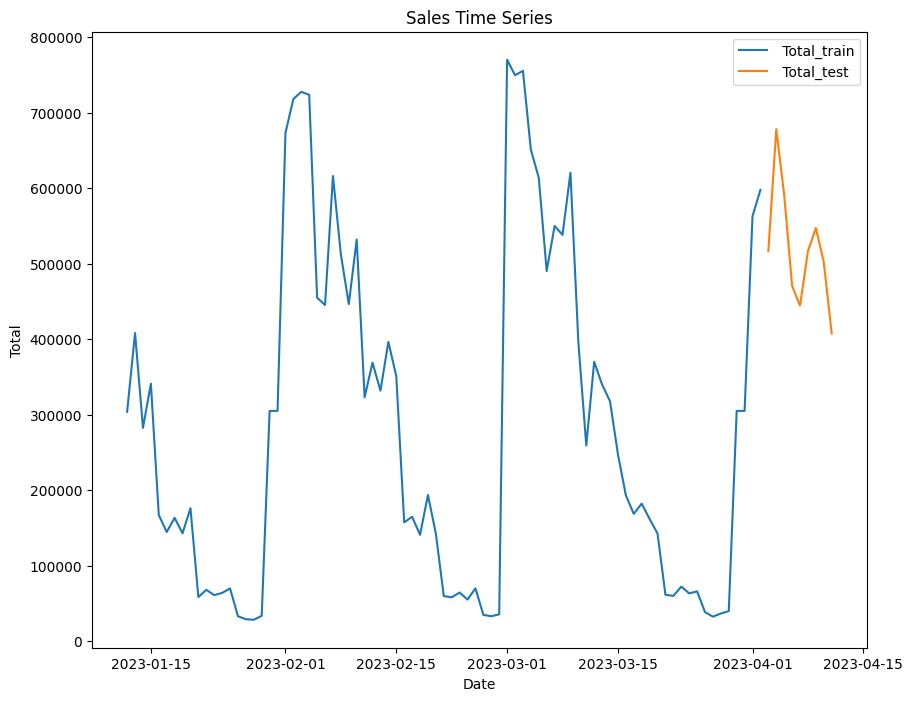

In [15]:
plt.figure(figsize=(10,8)) 

plt.plot(train['total'] , label=' Total_train') 
plt.plot(test['total'] , label=' Total_test') 

plt.title('Sales Time Series') 

plt.xlabel("Date") 
plt.ylabel("Total") 

plt.legend(loc='best')

In [16]:
from autots import AutoTS

import warnings
warnings.filterwarnings('ignore')

train = train.reset_index()
test = test.reset_index()

forecast_length = len(test)

model = AutoTS(forecast_length=forecast_length, frequency='infer', ensemble='simple')

model = model.fit(train, date_col='date', value_col='total')

Using 1 cpus for n_jobs.
Data frequency is: D, used frequency is: D
Model Number: 1 with model ARIMA in generation 0 of 20
Model Number: 2 with model AverageValueNaive in generation 0 of 20
Model Number: 3 with model AverageValueNaive in generation 0 of 20
Model Number: 4 with model AverageValueNaive in generation 0 of 20
Model Number: 5 with model DatepartRegression in generation 0 of 20
Model Number: 6 with model DatepartRegression in generation 0 of 20
Model Number: 7 with model DatepartRegression in generation 0 of 20
Model Number: 8 with model DatepartRegression in generation 0 of 20
Template Eval Error: ImportError('Tensorflow not available, install with pip install tensorflow.') in model 8 in generation 0: DatepartRegression
Model Number: 9 with model ETS in generation 0 of 20
Model Number: 10 with model ETS in generation 0 of 20
Model Number: 11 with model GLM in generation 0 of 20
Model Number: 12 with model GLM in generation 0 of 20
Model Number: 13 with model GLS in generati

In [17]:
prediction = model.predict()

forecast = prediction.forecast

forecast

,total
2023-04-03,597735.461043
2023-04-04,597735.461043
2023-04-05,454905.682349
2023-04-06,549895.487139
2023-04-07,549895.487139
2023-04-08,469472.308660
2023-04-09,440612.185291
2023-04-10,446424.451181
2023-04-11,322994.621705


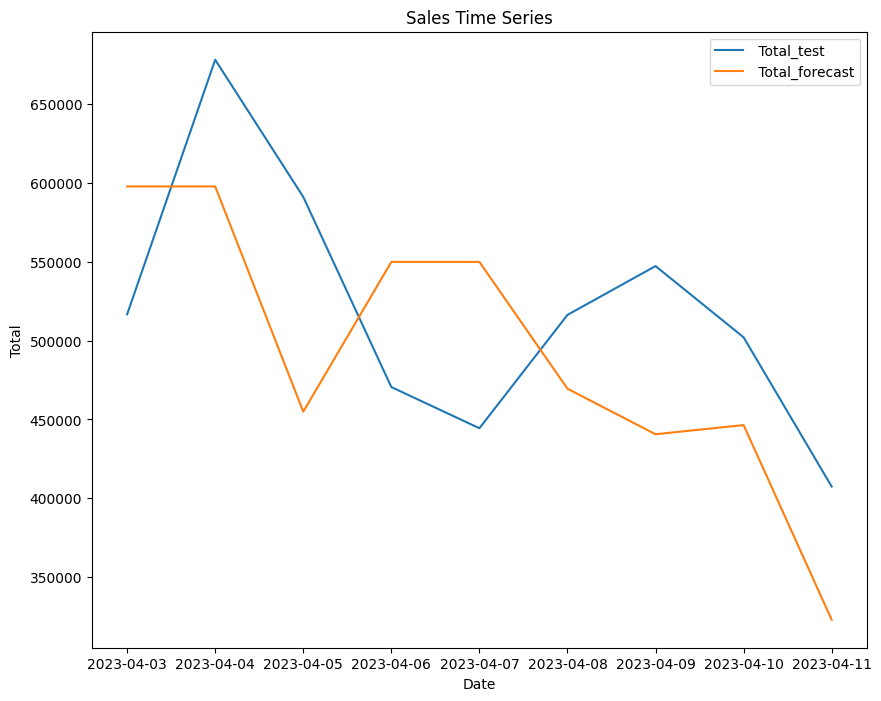

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8)) 

test = test.set_index("date")
plt.plot(test['total'] , label=' Total_test') 
plt.plot(forecast['total'] , label=' Total_forecast') 

plt.title('Sales Time Series') 

plt.xlabel("Date") 
plt.ylabel("Total") 

plt.legend(loc='best')

In [19]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(test.total, forecast.total))
print("RMSE = ", round(rmse))

RMSE =  89937


In [20]:
print ("Max = ", round(test.total.max()))
print ("Min = ", round(test.total.min()))

Max =  678098
Min =  407430


In [21]:
enddate = get_last_date()

startdate = enddate-timedelta(days=60)

enddate = enddate.strftime('%Y-%m-%d')
startdate = startdate.strftime('%Y-%m-%d')
df = get_daily_sales_between_2_dates(startdate, enddate)

df

,date,total
0,2023-02-11,322994.621705
1,2023-02-12,368789.834754
2,2023-02-13,331672.604119
3,2023-02-14,396309.916807
4,2023-02-15,350940.804181
5,2023-02-16,157294.814722
6,2023-02-17,164655.238002
7,2023-02-18,140748.324982
8,2023-02-19,193547.784774
9,2023-02-20,142299.949973


In [22]:
df['date'] = pd.to_datetime(df['date'])

df = df.set_index("date")

df = df.resample('D').mean()

df['total']=df['total'].fillna(df['total'].mean())

df = df.reset_index()


forecast_length = 10

model = AutoTS(forecast_length=forecast_length, frequency='infer')

model = model.fit(df, date_col='date', value_col='total')

Using 1 cpus for n_jobs.
Data frequency is: D, used frequency is: D
Model Number: 1 with model ARIMA in generation 0 of 20
Model Number: 2 with model AverageValueNaive in generation 0 of 20
Model Number: 3 with model AverageValueNaive in generation 0 of 20
Model Number: 4 with model AverageValueNaive in generation 0 of 20
Model Number: 5 with model DatepartRegression in generation 0 of 20
Model Number: 6 with model DatepartRegression in generation 0 of 20
Model Number: 7 with model DatepartRegression in generation 0 of 20
Model Number: 8 with model DatepartRegression in generation 0 of 20
Template Eval Error: ImportError('Tensorflow not available, install with pip install tensorflow.') in model 8 in generation 0: DatepartRegression
Model Number: 9 with model ETS in generation 0 of 20
Model Number: 10 with model ETS in generation 0 of 20
Model Number: 11 with model GLM in generation 0 of 20
Model Number: 12 with model GLM in generation 0 of 20
Model Number: 13 with model GLS in generati

In [23]:
prediction = model.predict()

forecast = prediction.forecast

forecast

,total
2023-04-12,350940.804181
2023-04-13,317692.205746
2023-04-14,369910.745623
2023-04-15,350940.804181
2023-04-16,168546.681012
2023-04-17,193089.582101
2023-04-18,182054.455945
2023-04-19,168546.681012
2023-04-20,164655.238002
2023-04-21,140748.324982


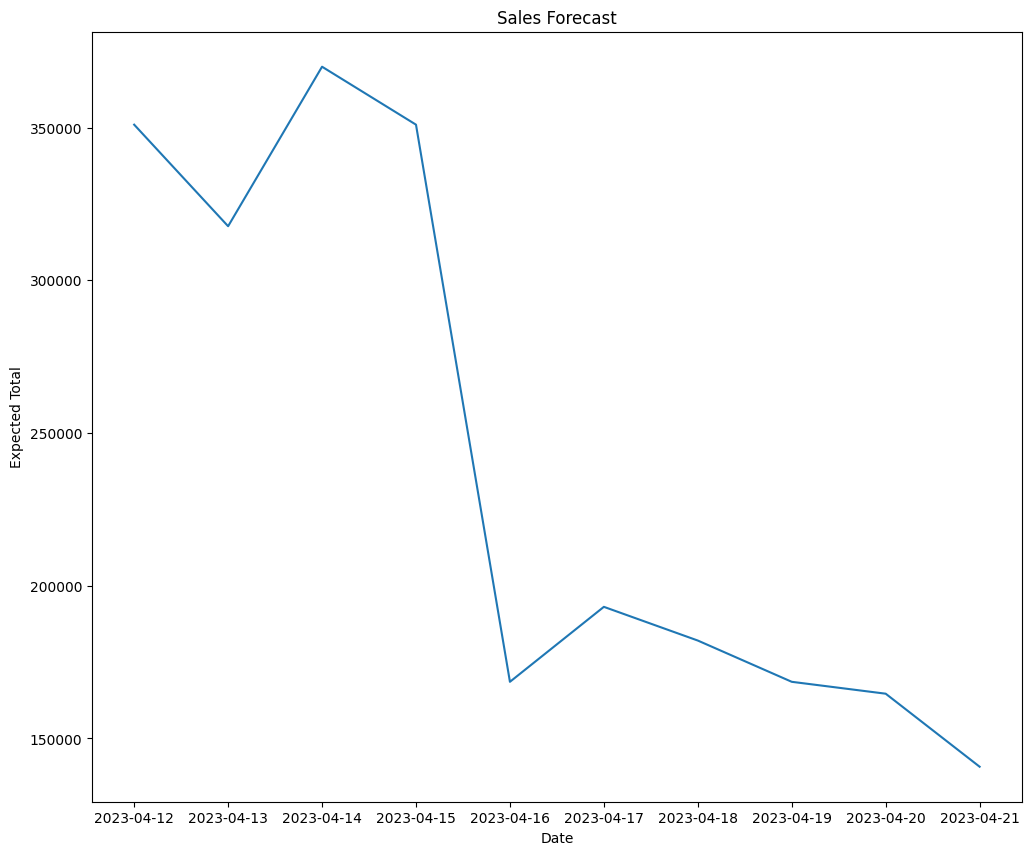

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10)) 

plt.plot(forecast.index, forecast['total'])

plt.xlabel("Date")   

plt.ylabel("Expected Total")

plt.title("Sales Forecast")
plt.show()

In [25]:
sql = '''DROP TABLE IF EXISTS custom_forecast'''
cursor.execute(sql)

sql = '''
        CREATE TABLE custom_forecast 
        (ID INT NOT NULL AUTO_INCREMENT, 
        date datetime NOT NULL,
        total float NOT NULL,
        PRIMARY KEY (id)) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4;
       '''
cursor.execute(sql)
connection_mydb.commit()

for index, row in forecast.iterrows():
    date = index.strftime('%Y-%m-%d %H:%M:%S')
    total = float(row['total'])
    sql = "INSERT INTO custom_forecast (date, total) VALUES (%s, %s)"
    params = (date, total)
    cursor.execute(sql, params)
    connection_mydb.commit()

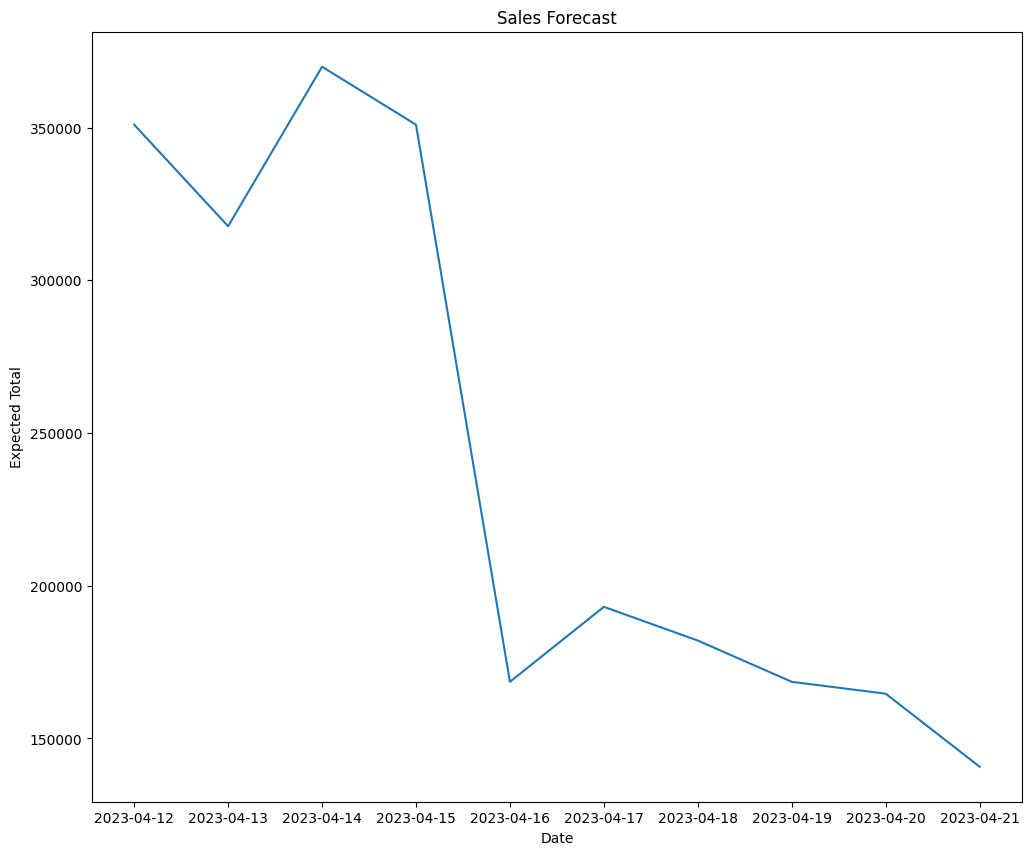

In [26]:
plt.figure(figsize=(12,10)) 

sql = '''SELECT * from custom_forecast'''

cursor.execute(sql)

results = cursor.fetchall()

df = pd.DataFrame(columns=['date','total'])

for row in results:
    obj = {
        "date":row['date'],
        "total":row['total']
    }
    
    df = pd.concat([df, pd.DataFrame([obj])], ignore_index=True)

plt.plot(df['date'],df['total'])

plt.xlabel("Date")   

plt.ylabel("Expected Total")

plt.title("Sales Forecast")

plt.show()